# architecture-27 ( Basic Classification ) v-11

## What's new:

1-


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Reshape, TimeDistributed, Lambda, LayerNormalization, Bidirectional
from tensorflow.keras import Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import talib
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight



In [ ]:
# 1- Load and Scaling Features
# Load and preprocess
df = pd.read_csv('datasets-27/XAGUSD-H1-rates.csv', sep='\t')

# Rename columns for easier access
df.rename(columns={
    '<DATE>': 'DATE',
    '<TIME>': 'TIME',
    '<OPEN>': 'OPEN',
    '<HIGH>': 'HIGH',
    '<LOW>': 'LOW',
    '<CLOSE>': 'CLOSE',
    '<TICKVOL>': 'TICKVOL',
    '<VOL>': 'VOL',
    '<SPREAD>': 'SPREAD'
}, inplace=True)

# Optional: Combine DATE and TIME into a single datetime column
df['DATETIME'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'], errors='coerce')

# Drop rows with missing values
df.dropna(inplace=True)

# Sort data chronologically by DATETIME
df.sort_values(by='DATETIME', inplace=True)

# Reset index to ensure clean row order
df.reset_index(drop=True, inplace=True)

# Select features to scale
feature_cols = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICKVOL']

# Normalize features
scaler = MinMaxScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

In [ ]:
# 2- Label trend reversals
def label_reversal_points(prices, window=8, threshold=0.002):
    prices = np.asarray(prices)
    labels = [0] * len(prices)
    prev_trend = 0  # 1 = up, -1 = down, 0 = unknown

    for i in range(len(prices) - window):
        past = prices[i:i + window // 2]
        future = prices[i + window // 2:i + window]

        past_mean = np.mean(past)
        future_mean = np.mean(future)
        change = (future_mean - past_mean) / past_mean

        if change > threshold:
            curr_trend = 1  # Uptrend
        elif change < -threshold:
            curr_trend = -1  # Downtrend
        else:
            curr_trend = 0  # No significant trend

        # Detect a reversal (trend direction changed)
        if prev_trend == -1 and curr_trend == 1:
            labels[i + window // 2] = 1  # Buy signal at start of uptrend
        elif prev_trend == 1 and curr_trend == -1:
            labels[i + window // 2] = 2  # Sell signal at start of downtrend

        # Update previous trend only if there is a new clear trend
        if curr_trend != 0:
            prev_trend = curr_trend

    return labels

df['Label'] = label_reversal_points(df['CLOSE'].values)

In [ ]:
def plot_labeled_candles(df, n=150):
    """
    Plots the last n candles with BUY/SELL labels based on the 'Label' column.
    """
    # Use only the last n rows
    df_plot = df.tail(n).copy()
    df_plot['DATETIME'] = df_plot['DATE'] + ' ' + df_plot['TIME']

    # Plot the closing price
    plt.figure(figsize=(15, 6))
    plt.plot(df_plot['DATETIME'], df_plot['CLOSE'], label='Close Price', color='black', linewidth=1.5)

    # Plot BUY (label=1) and SELL (label=2) signals
    for idx, row in df_plot.iterrows():
        if row['Label'] == 1:
            plt.axvline(x=row['DATETIME'], color='green', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'BUY', color='green', ha='center', va='bottom', fontsize=9)
        elif row['Label'] == 2:
            plt.axvline(x=row['DATETIME'], color='red', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'SELL', color='red', ha='center', va='top', fontsize=9)

    plt.title(f'Last {n} Candles with Trend Reversal Labels')
    plt.xlabel('Datetime')
    plt.ylabel('Close Price')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.legend()
    plt.show()

In [ ]:
plot_labeled_candles(df)

In [ ]:
# 3- Create sequences
SEQ_LEN = 60      # past candles for input
FORECAST_HORIZON = 10  # predict next 10 candles
NUM_CLASSES = 3   # 0 = no signal, 1 = buy, 2 = sell
X, y = [], []
for i in range(len(df) - SEQ_LEN - FORECAST_HORIZON + 1):
    seq_x = df[feature_cols].iloc[i : i + SEQ_LEN].values
    seq_y = df['Label'].iloc[i + SEQ_LEN : i + SEQ_LEN + FORECAST_HORIZON].values
    X.append(seq_x)
    y.append(seq_y)

X = np.array(X)
y = np.array(y)

In [9]:
# 4- One-hot encode labels for each timestep
y_onehot = np.array([to_categorical(seq, num_classes=NUM_CLASSES) for seq in y])

In [10]:
# 5- Train-test split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y_onehot[:split], y_onehot[split:]

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

X_train: (44011, 60, 5)
y_train: (44011, 10, 3)


In [11]:
# 6- Handle Class Imbalance

from sklearn.utils.class_weight import compute_class_weight

# Flatten labels to compute weights
y_flat = np.argmax(y_train, axis=-1).flatten()
class_weights_values = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(NUM_CLASSES),
    y=y_flat
)
class_weights = dict(enumerate(class_weights_values))
print("Class weights:", class_weights)

Class weights: {0: np.float64(0.3769036369817907), 1: np.float64(5.766640461215933), 2: np.float64(5.767320569773689)}


In [12]:
# 7- Build LSTM Classification Model
# ==============================

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed

from tensorflow.keras.layers import RepeatVector

model = Sequential([
    LSTM(128, return_sequences=False, input_shape=(SEQ_LEN, len(feature_cols))),
    Dropout(0.3),
    RepeatVector(FORECAST_HORIZON),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    TimeDistributed(Dense(NUM_CLASSES, activation='softmax'))
])

import tensorflow.keras.backend as K

# Convert your class_weights dict to a tensor
weights = np.array([class_weights[i] for i in range(NUM_CLASSES)], dtype=np.float32)

def weighted_categorical_crossentropy(weights):
    weights_tensor = K.constant(weights)

    def loss_fn(y_true, y_pred):
        # Avoid log(0)
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # Calculate loss for each class and apply weights
        loss = y_true * K.log(y_pred) * weights_tensor
        loss = -K.sum(loss, axis=-1)  # sum over classes
        return loss
    return loss_fn

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=weighted_categorical_crossentropy(weights),
    metrics=['accuracy']
)


I0000 00:00:1755157573.246758    4187 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2390 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5
/home/saeed/repositories/machine-learning/forex-prediction/envs/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
# 8. Fit model with EarlyStopping
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=2,
    batch_size=64
)
# shuffle=False,  # Important: keep time order! ?????


Epoch 1/2


I0000 00:00:1755157622.160615    4286 cuda_dnn.cc:529] Loaded cuDNN version 91001


688/688 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.2739 - loss: 1.0990 - val_accuracy: 0.6662 - val_loss: 1.0581
Epoch 2/2
688/688 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.2970 - loss: 1.0996 - val_accuracy: 0.8912 - val_loss: 1.0581


In [20]:
# 9- Load the last 60 candles from a CSV file
# Load and clean
input_df = pd.read_csv('datasets-27/new-data-for-test/rows-60-from-20240503/rows-60-from-20240503.csv', sep='\t')
input_df.dropna(inplace=True)

input_df.rename(columns={
    '<DATE>': 'DATE',
    '<TIME>': 'TIME',
    '<OPEN>': 'OPEN',
    '<HIGH>': 'HIGH',
    '<LOW>': 'LOW',
    '<CLOSE>': 'CLOSE',
    '<TICKVOL>': 'TICKVOL',
    '<VOL>': 'VOL',
    '<SPREAD>': 'SPREAD'
}, inplace=True)

# Add datetime
input_df['DATETIME'] = pd.to_datetime(input_df['DATE'] + ' ' + input_df['TIME'])

# Ensure column order matches training
input_features = input_df[feature_cols].values

# Scale features using the same scaler used in training
input_scaled = scaler.transform(input_features)

# Reshape for LSTM input: (1 sample, SEQ_LEN timesteps, features)
input_seq = np.expand_dims(input_scaled, axis=0)

# Predict class probabilities for each of the 10 future timesteps
pred_probs = model.predict(input_seq)  # Shape: (1, FORECAST_HORIZON, NUM_CLASSES)
pred_probs = pred_probs[0]  # Remove batch dim → (10, NUM_CLASSES)

# Get predicted classes (0 = no signal, 1 = buy, 2 = sell)
pred_classes = np.argmax(pred_probs, axis=-1)

# Create output DataFrame with the next 10 hours
# Assuming input_df contains a 'DATE' and 'TIME' for the last candle
last_timestamp = pd.to_datetime(
    input_df.iloc[-1]['DATE'] + ' ' + input_df.iloc[-1]['TIME']
)

# Generate next 10 hourly timestamps
future_times = [last_timestamp + pd.Timedelta(hours=i+1) for i in range(FORECAST_HORIZON)]

predicted_df = pd.DataFrame({
    'Timestamp': future_times,
    'Predicted_Class': pred_classes
})

# Optional: Map class IDs to readable labels
class_map = {0: 'No Signal', 1: 'Buy', 2: 'Sell'}
predicted_df['Signal'] = predicted_df['Predicted_Class'].map(class_map)

# Filter only reversal points (Buy/Sell)
predicted_reversals = predicted_df[predicted_df['Predicted_Class'] != 0]

print("\nPredicted trend reversal points in the next 10 hours:")
print(predicted_reversals)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Predicted trend reversal points in the next 10 hours:
Empty DataFrame
Columns: [Timestamp, Predicted_Class, Signal]
Index: []


/home/saeed/repositories/machine-learning/forex-prediction/envs/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


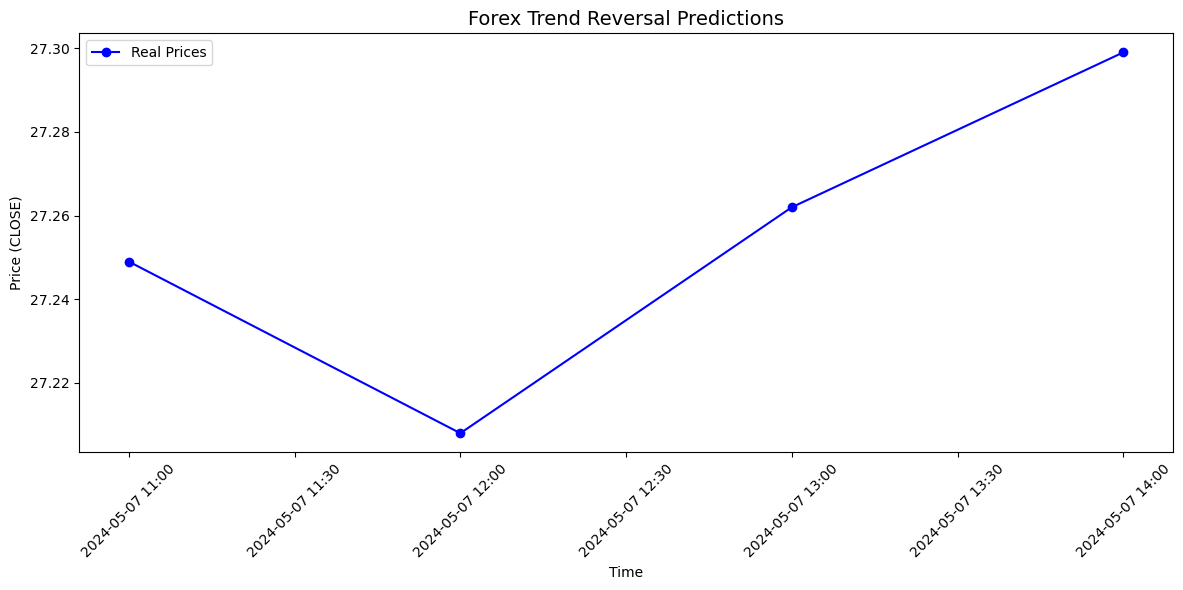

In [21]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# -------------------------------------------------
# Visualization
# -------------------------------------------------

# Take last 4 real candles from input_df
last_real = input_df.iloc[-4:].copy()
last_real['Timestamp'] = pd.to_datetime(last_real['DATE'] + ' ' + last_real['TIME'])

# Merge real + predicted data for plotting
plot_df = pd.concat([
    last_real[['Timestamp', 'CLOSE']],
    pd.DataFrame({
        'Timestamp': predicted_df['Timestamp'],
        'CLOSE': np.nan  # Unknown future prices
    })
], ignore_index=True)

# Create plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the real prices
ax.plot(last_real['Timestamp'], last_real['CLOSE'], marker='o', label='Real Prices', color='blue')

# Plot predicted prices as dotted line (if available, else keep blank)
# Here we don't have actual future CLOSE prices, so we just extend the timeline

# Mark reversal points
for idx, row in predicted_df.iterrows():
    if row['Predicted_Class'] == 1:  # Buy
        ax.axvline(x=row['Timestamp'], color='green', linestyle='--', alpha=0.7)
        ax.text(row['Timestamp'], ax.get_ylim()[1]*0.95, 'BUY', color='green',
                rotation=90, verticalalignment='top', horizontalalignment='center')
    elif row['Predicted_Class'] == 2:  # Sell
        ax.axvline(x=row['Timestamp'], color='red', linestyle='--', alpha=0.7)
        ax.text(row['Timestamp'], ax.get_ylim()[1]*0.95, 'SELL', color='red',
                rotation=90, verticalalignment='top', horizontalalignment='center')

# Formatting
ax.set_title("Forex Trend Reversal Predictions", fontsize=14)
ax.set_xlabel("Time")
ax.set_ylabel("Price (CLOSE)")
ax.legend()

# Format x-axis for datetime
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# plot section

In [22]:
# 10- Plot section

import sys

sys.path.insert(1, '../utils')
import forex_plot_utils
import os
import pandas as pd

# 10-1 PARAMETERS
csv1_path = 'datasets-27/new-data-for-test/rows-60-from-20240503/latest-4-for-history.csv'
csv3_path = 'datasets-27/new-data-for-test/rows-60-from-20240503/after.csv'
plot_title = 'Write a suitable title.'
output_plot_path = None  # e.g., 'output.png'

# 10-2 LOAD DATA FROM CSVS
historical_df = forex_plot_utils.load_csv_with_datetime(csv1_path) if os.path.exists(csv1_path) else None
actual_future_df = forex_plot_utils.load_csv_with_datetime(csv3_path) if os.path.exists(csv3_path) else None
# 10-3 Generate forecast timestamps ===
# Start 1 hour after the last actual candle
last_timestamp = input_df['DATETIME'].iloc[-1]
forecast_datetimes = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1), periods=FORECAST_HORIZON, freq='h')

# 10-4 Create predicted_df with forecasted trend reversals
predicted_df = pd.DataFrame({
    'DATETIME': forecast_datetimes,
    'forecast_class': pred_classes
})


# 10-5 Optional: Add labels for plotting
def class_to_label(c):
    if c == 1:
        return 'buy'
    elif c == 2:
        return 'sell'
    else:
        return None


predicted_df['label'] = predicted_df['forecast_class'].apply(class_to_label)


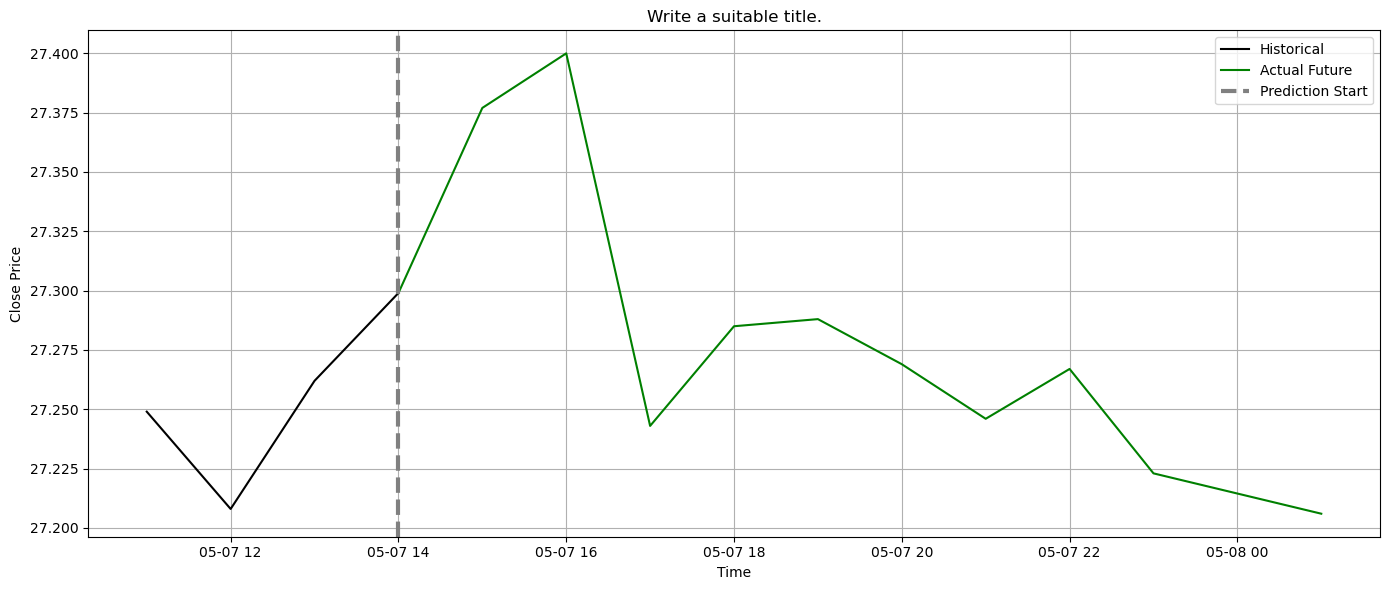

In [23]:
# 10-6 PLOT

forex_plot_utils.plot_all_series(
    historical_df=historical_df,
    predicted_df=predicted_df,
    actual_future_df=actual_future_df,
    title=plot_title,
    output_path=output_plot_path
)

In [24]:
# 11- Save Model

from datetime import datetime
import os
import pandas as pd
import matplotlib.pyplot as plt

# 11-1 Create timestamp and paths
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f'model_{timestamp}.keras'
model_path = os.path.join('saved_models', model_filename)

# 11-2 Directory to hold logs and extras
log_dir = os.path.join('saved_models', f'model_{timestamp}_logs')
os.makedirs(log_dir, exist_ok=True)

# 11-3 Save model
model.save(model_path)

# 11-4 Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(log_dir, 'training_history.csv'), index=False)

# 11-5 Save training loss plot
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(log_dir, 'training_loss.png'))
plt.close()

# 11-6 Save model summary and final performance
y_test_onehot = to_categorical(y_test, num_classes=3)

with open(os.path.join(log_dir, 'model_log.txt'), 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
    final_train_loss = history.history['loss'][-1]
    final_test_loss, final_test_accuracy, final_test_mae = model.evaluate(X_test, y_test_onehot, verbose=0)

    f.write(f'\nFinal Training Loss: {final_train_loss:.6f}\n')
    f.write(f'Final Test Loss: {final_test_loss:.6f}\n')
    f.write(f'Final Test Accuracy: {final_test_accuracy:.6f}\n')

ValueError: Cannot take the length of shape with unknown rank.